In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels, DatasetBuilder



import seaborn as sns

In [24]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [25]:
DEVICE='cpu'

In [26]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=842, out_features=64, bias=False)
  (batchNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (hidden2): Linear(in_features=32, out_features=21, bias=True)
)

## Load test dataset

In [27]:
# dataset_name = 'angular'
# dataset_name = 'html-5'
# dataset_name = 'react-ant'
# dataset_name = 'mobile-and-html-5'
# dataset_name = 'bootstrap'
# dataset_name = 'dummy'
# dataset_name = 'google'
# dataset_name = 'cnews'

In [30]:
class TestDataset(DatasetBuilder):
    def setUp(self, driver):
        self.driver.set_window_size(width=1920, height=1090)
        super(TestDataset, self).setUp(driver=driver)
        

In [31]:
TestDataset(url='https://ac-avto161.ru/', dataset_name='ac-avto161')
dataset_name = 'ac-avto161'

2021-03-24 14:06:04,862 - INFO - dataset:dataset.py:181 - Dataset name: ac-avto161
2021-03-24 14:06:04,863 - INFO - dataset:dataset.py:190 - Create directories to save the dataset
2021-03-24 14:06:04,864 - INFO - dataset:dataset.py:222 - Creating driver
2021-03-24 14:06:05,899 - INFO - dataset:dataset.py:229 - Chrome web driver is created
2021-03-24 14:06:06,014 - INFO - dataset:dataset.py:260 - getting url: https://ac-avto161.ru/
2021-03-24 14:06:13,793 - INFO - common:common.py:82 - Window maximized
2021-03-24 14:06:13,794 - INFO - dataset:dataset.py:232 - save scrinshot: dataset/images/ac-avto161.png
2021-03-24 14:06:15,297 - INFO - dataset:dataset.py:275 - Collect features using JS script
2021-03-24 14:06:15,887 - INFO - dataset:dataset.py:283 - Save html to dataset/html/ac-avto161.html
2021-03-24 14:06:15,912 - INFO - dataset:dataset.py:294 - Save parquet to dataset/df/ac-avto161.parquet


In [32]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-03-24 14:06:18,740 - INFO - dataset:dataset.py:337 - List of dataset_names:['ac-avto161']
2021-03-24 14:06:18,742 - INFO - dataset:dataset.py:342 - Dataset for ac-avto161
2021-03-24 14:06:18,782 - INFO - dataset:dataset.py:344 - Dataset shape: (794, 13)
2021-03-24 14:06:18,782 - INFO - dataset:dataset.py:346 - cleaning tag_name from dummy/auxiliary words
2021-03-24 14:06:18,787 - INFO - dataset:dataset.py:56 - select all leafs (nodes which are not parents)
2021-03-24 14:06:18,788 - INFO - dataset:dataset.py:58 - Leafs set size: 432 (nodes which have no children)
2021-03-24 14:06:18,790 - INFO - dataset:dataset.py:61 - count number of references to leafs
2021-03-24 14:06:18,791 - INFO - dataset:dataset.py:63 - Nodes with leafs as children set size: 224 (nodes which have leafs as children)
2021-03-24 14:06:18,793 - INFO - dataset:dataset.py:66 - count num children for each node
2021-03-24 14:06:18,793 - INFO - dataset:dataset.py:68 - Nodes with children: 363
2021-03-24 14:06:18,795 

In [33]:
dataset.dataset.shape

(794, 46)

In [34]:
dataset.labels

0      n/a
1      n/a
2      n/a
3      n/a
4      n/a
      ... 
789    n/a
790    n/a
791    n/a
792    n/a
793    n/a
Name: label, Length: 794, dtype: object

In [35]:
dataset.dataset.label

0      20
1      20
2      20
3      20
4      20
       ..
789    20
790    20
791    20
792    20
793    20
Name: label, Length: 794, dtype: int32

In [36]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1)

In [37]:
results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            y_pred = y_pred[0].argmax()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/794 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label
0,20,20,n/a,n/a
1,20,20,n/a,n/a
2,20,20,n/a,n/a
3,20,20,n/a,n/a
4,20,20,n/a,n/a
...,...,...,...,...
789,20,20,n/a,n/a
790,20,20,n/a,n/a
791,20,20,n/a,n/a
792,20,20,n/a,n/a


In [38]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox',
 'textarea',
 'label',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'radiobutton',
 'table',
 'n/a']

In [39]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true_label.values,
                     y_pred=results_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [40]:
confusion_matrix_df

,button,link,iframe,textfield,dropdown,checkbox,textarea,label,text,fileinput,...,colorpicker,range,progressbar,datetimeselector,numberselector,dropdownselector,checklist,radiobutton,table,n/a
button,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textfield,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
text,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fileinput,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
import seaborn as sns


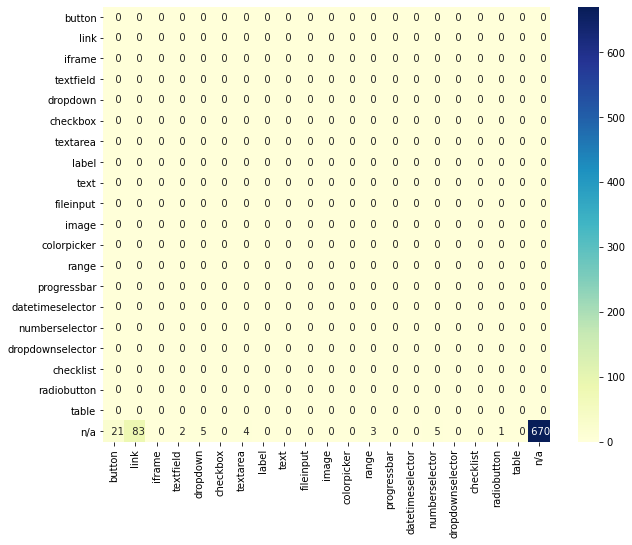

In [42]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [43]:
dataset_name

'ac-avto161'

In [44]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'iframe': 2,
 'textfield': 3,
 'dropdown': 4,
 'checkbox': 5,
 'textarea': 6,
 'label': 7,
 'text': 8,
 'fileinput': 9,
 'image': 10,
 'colorpicker': 11,
 'range': 12,
 'progressbar': 13,
 'datetimeselector': 14,
 'numberselector': 15,
 'dropdownselector': 16,
 'checklist': 17,
 'radiobutton': 18,
 'table': 19,
 'n/a': 20}

In [45]:

dataset.dataset['label_text_predicted'] = results_df.y_pred_label


(6221, 1903)


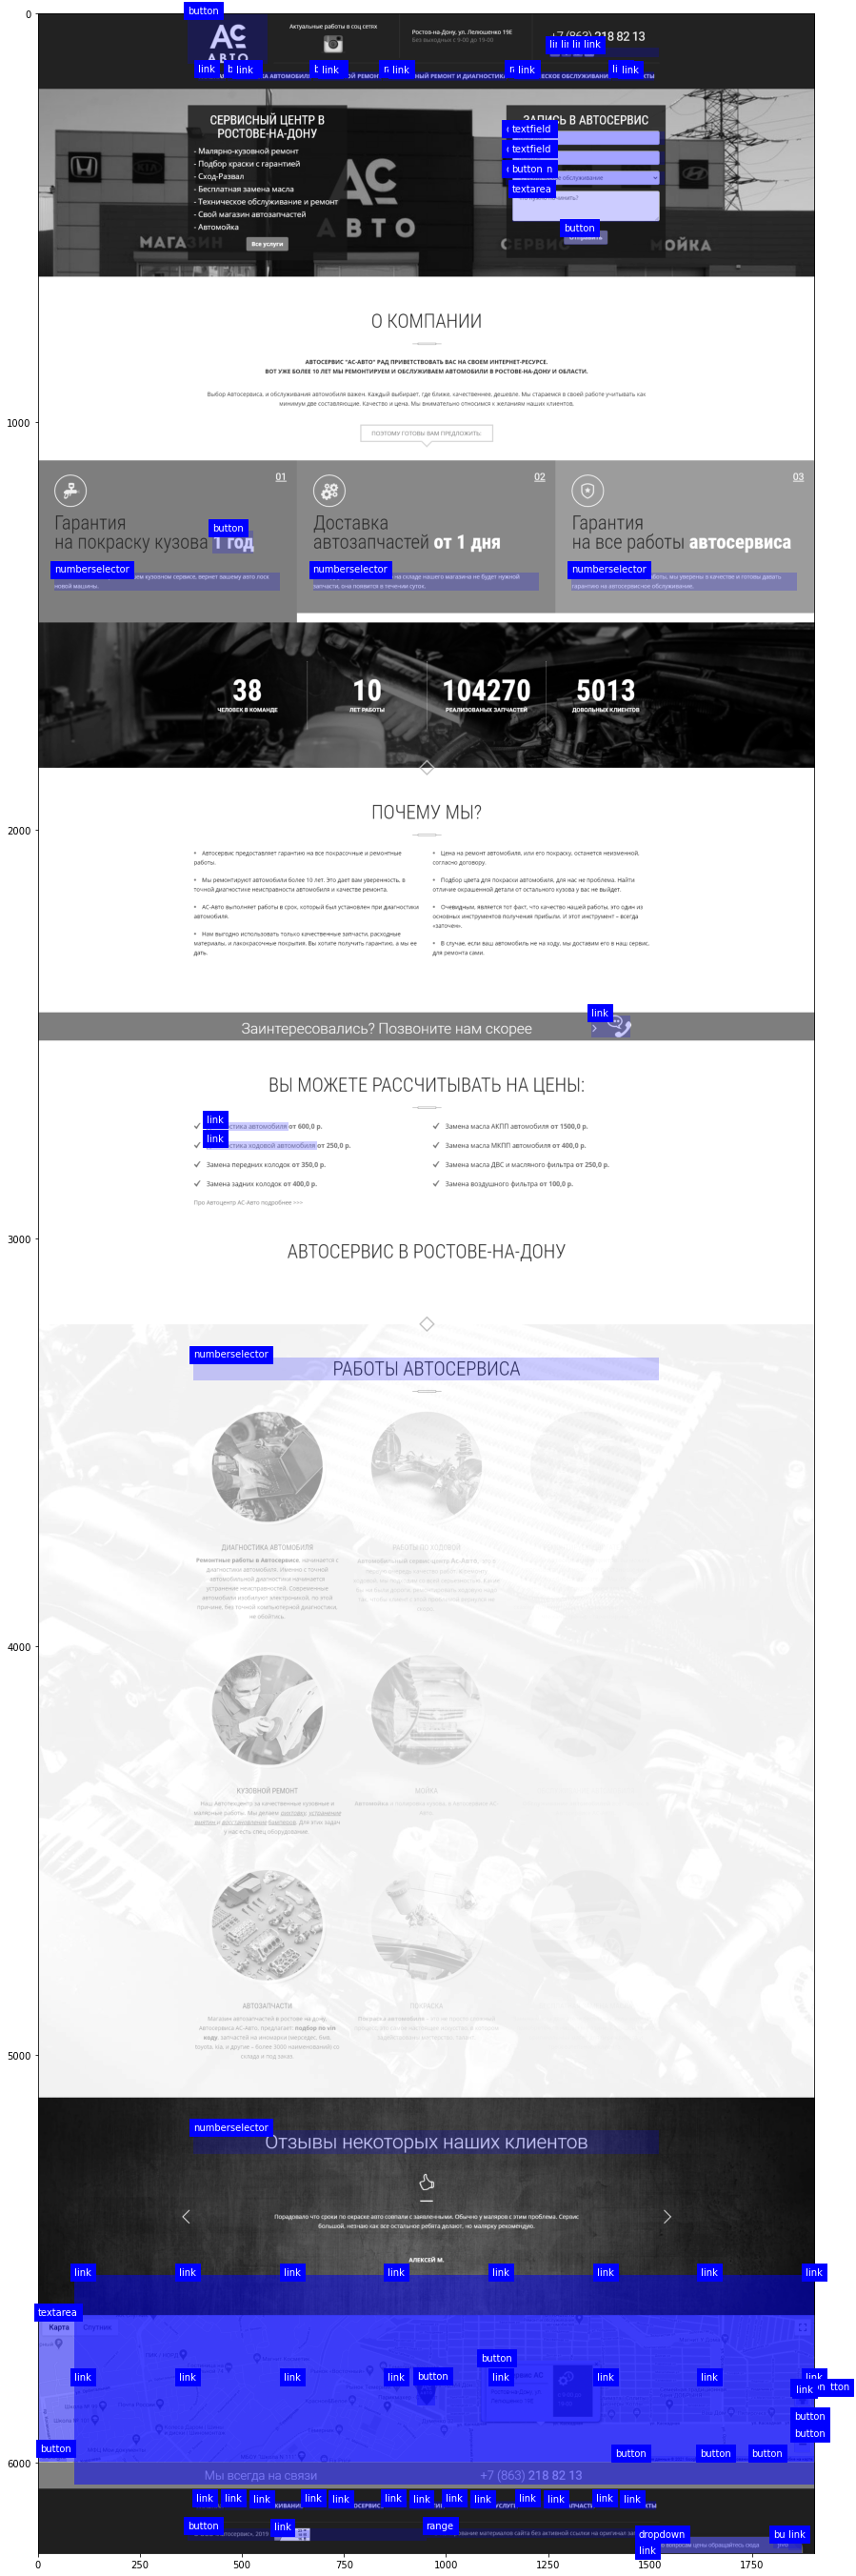

In [46]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset[dataset.dataset.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.dataset[dataset.dataset.label != dataset.dummy_class_value].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [21]:
results_df

,y_true,y_pred,y_true_label,y_pred_label
0,20,20,n/a,n/a
1,20,20,n/a,n/a
2,20,20,n/a,n/a
3,20,20,n/a,n/a
4,20,20,n/a,n/a
...,...,...,...,...
1093,1,1,link,link
1094,20,20,n/a,n/a
1095,1,1,link,link
1096,20,20,n/a,n/a


In [22]:
dataset.dataset[:1].to_json(orient='records')

'[{"attributes":{"alt":null,"aria-atomic":null,"aria-controls":null,"aria-current":null,"aria-describedby":null,"aria-disabled":null,"aria-expanded":null,"aria-haspopup":null,"aria-hidden":null,"aria-label":null,"aria-labelledby":null,"aria-live":null,"aria-valuemax":null,"aria-valuemin":null,"aria-valuenow":null,"charset":null,"checked":null,"class":null,"content":null,"data-animation":null,"data-dismiss":null,"data-offset":null,"data-original-title":null,"data-pause":null,"data-placement":null,"data-slide":null,"data-slide-to":null,"data-spy":null,"data-target":null,"data-toggle":null,"dir":null,"disabled":null,"dy":null,"fill":null,"focusable":null,"for":null,"height":null,"href":null,"http-equiv":null,"id":null,"index":null,"lang":"en","language":null,"max":null,"min":null,"name":null,"onchange":null,"onclick":null,"oncontextmenu":null,"ondblclick":null,"oninput":null,"placeholder":null,"preserveAspectRatio":null,"rel":null,"role":null,"src":null,"step":null,"style":null,"tabindex"